# Face points detection

* use shape_predictor_68_face_landmarks
* use shape_predictor_5_face_landmarks

# Links

* [Dlib files](http://dlib.net/files/)

In [ ]:
import dlib
import cv2
from typing import List, Tuple, Dict
from pathlib import Path
from PIL import Image
import numpy as np
from common import CV_DATASETS_DIR, show_full_image_plot, show_image_plot

SHAPE_PREDICTOR_68 = "shape_predictor_68_face_landmarks.dat"
SHAPE_PREDICTOR_05 = "shape_predictor_5_face_landmarks.dat"
FACE_RESNET_MODEL = "dlib_face_recognition_resnet_model_v1.dat"

face_detector = dlib.get_frontal_face_detector()
points_detector_68 = dlib.shape_predictor(str(CV_DATASETS_DIR / "models" / SHAPE_PREDICTOR_68))
face_descriptor_extractor = dlib.face_recognition_model_v1(str(CV_DATASETS_DIR / "models" / FACE_RESNET_MODEL))

def get_image_data(path: Path) -> (List[np.array], List[Path]):
    images = []
    labels = []
    files = path.glob('*.gif')
    for file in files:
        images.append(np.array(Image.open(file).convert("RGB"), "uint8"))
        labels.append(file)
    return images, labels


def get_images_descriptors(images: List[np.array], labels: List[Path]) -> Tuple[Dict[int, Path], any]:
    idx = 0
    index = {}
    descriptors = None
    for image, label in zip(images, labels):
        for face in face_detector(image, 1):
            points = points_detector_68(image, face)
            assert len(points.parts()) > 0
            descriptor = face_descriptor_extractor.compute_face_descriptor(image, points)
            descriptor = [_ for _ in descriptor]
            descriptor = np.asarray(descriptor, dtype=np.float64)
            descriptor = descriptor[np.newaxis, :]
            if descriptors is None:
                descriptors = descriptor
            else:
                descriptors = np.concatenate((descriptors, descriptor), axis=0)
            index[idx] = label
            idx += 1  
    return index, descriptors

In [ ]:
train_images, train_labels = get_image_data(CV_DATASETS_DIR / 'images' / 'yalefaces' / 'train')
train_index, train_descriptors = get_images_descriptors(train_images, train_labels)

In [73]:
test_images, test_labels = get_image_data(CV_DATASETS_DIR / 'images' / 'yalefaces' / 'test')
test_index, test_descriptors = get_images_descriptors(test_images, test_labels)

Accuracy: 100.000%


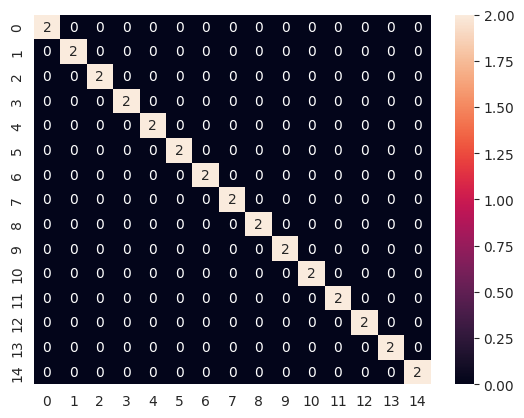

In [85]:
import seaborn
from sklearn.metrics import accuracy_score, confusion_matrix

MIN_THRESHOLD = 0.5

preds = []
reals = []

for index, image, descriptor in zip(test_index, test_images, test_descriptors):
    distances = np.linalg.norm(descriptor - train_descriptors, axis=1)
    min_i = np.argmin(distances)
    min_d = distances[min_i]
    if min_d <= MIN_THRESHOLD:
        pred = int(train_index[min_i].stem.split(".")[0].replace("subject", ""))
    else:
        pred = -1
    real = int(test_index[index].stem.split(".")[0].replace("subject", ""))
    preds.append(pred)
    reals.append(real)
    
preds = np.array(preds)
reals = np.array(reals)

accuracy = accuracy_score(reals, preds)
print(f'Accuracy: {accuracy * 100:.3f}%')
cm = confusion_matrix(reals, preds)
seaborn.heatmap(cm, annot=True);